# Dog Breed Identification - Kaggle competition

## Init

* Load the training set.
* View a couple of images.
* Create a one layer model.
* Get a place on the leaderboard.

In [55]:
import os
import time
import random
import fnmatch
from shutil import copyfile, rmtree
import csv
import math

import pandas
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np
np.random.seed(42)
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.layers import Input, Dense, Flatten, BatchNormalization
from keras.layers import GlobalAveragePooling2D, Dropout
from keras.optimizers import Adam
from keras.layers import BatchNormalization
from keras.models import Sequential, Model
from keras.regularizers import l2
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


%matplotlib inline

In [2]:
def to_plot(img):
    return np.rollaxis(img, 0, 1).astype(np.uint8)


def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    """Taken from Fast.ai utils."""
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')
        
        
def get_steps(gen):
    """
    Generally define an epoch as an entire pass through the dataset.
    
    Therefore, we say that steps per epoch = num samples / batch size.
    """
    return gen.samples / gen.batch_size


def generate_submission(predictions, gen, output_file='sub.csv'):  
    fh = open(output_file, 'w')
    writer = csv.writer(fh)
    writer.writerow(['id'] + [i[1] for i in sorted(label_to_id.items(), key=lambda x: x[0])])
    for filename, prediction in zip(gen.filenames, predictions):
        dog_id = filename.split('/')[-1].split('.')[0]
        writer.writerow([dog_id] + ['{0:f}'.format(p) for p in prediction])
    fh.close()

### Prepare training set

In [3]:
labels = pandas.read_csv('data/labels.csv')

In [4]:
labels.describe()

,id,breed
count,10222,10222
unique,10222,120
top,9ac3aa31819e0fbc75bb8323127a2941,scottish_deerhound
freq,1,126


Thinking a 90/10 training/dev split = 900 in the dev set.

Time to get it into a format that Keras likes.

In [5]:
if os.path.exists('./data/prepared'):
    rmtree('./data/prepared')

for label in labels.breed.unique():
    os.makedirs(f'./data/prepared/train/{label}', exist_ok=True)
    os.makedirs(f'./data/prepared/dev/{label}', exist_ok=True)
    os.makedirs(f'./data/prepared/sample/{label}', exist_ok=True)

for _, item_id, label in labels.itertuples():
    is_dev = random.random() > 0.9
    is_sample = random.random() > 0.85
    
    which_set = 'dev' if is_dev else 'train'
    copyfile(
        f'./data/train/{item_id}.jpg',
        f'./data/prepared/{which_set}/{label}/{item_id}.jpg')
    
    if is_sample:
        copyfile(
        f'./data/train/{item_id}.jpg',
        f'./data/prepared/sample/{label}/{item_id}.jpg')

In [5]:
_gen = ImageDataGenerator().flow_from_directory('./data/prepared/train', batch_size=4, class_mode='sparse')
x_batch, y_batch = next(_gen)

Found 9162 images belonging to 120 classes.


In [6]:
label_to_id = {id: label for label, id in _gen.class_indices.items()}

In [7]:
titles = [label_to_id[i] for i in y_batch]

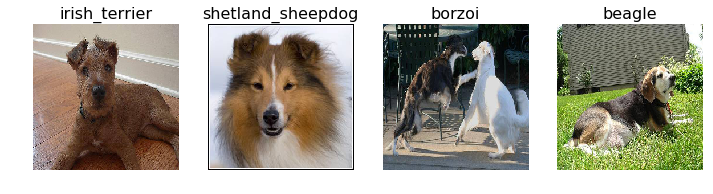

In [8]:
plots(x_batch, titles=titles)

In [67]:
train_datagen = ImageDataGenerator(rescale=1./255)

In [68]:
train_gen = train_datagen.flow_from_directory('./data/prepared/train')
dev_gen = train_datagen.flow_from_directory('./data/prepared/dev')
sample_gen = train_datagen.flow_from_directory('./data/prepared/sample')

Found 9162 images belonging to 120 classes.
Found 1060 images belonging to 120 classes.
Found 1534 images belonging to 120 classes.


In [69]:
test_datagen = ImageDataGenerator(rescale=1./255)

### Create baseline model

In [15]:
print("Image size:", x_batch.shape)

Image size: (4, 256, 256, 3)


In [16]:
model = Sequential([
    BatchNormalization(input_shape=(256, 256, 3)),
    Flatten(),
    Dense(_gen.num_class, activation='softmax')])

model.compile(
    optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
model.fit_generator(train_gen, epochs=2, steps_per_epoch=get_steps(sample_gen), validation_data=dev_gen, validation_steps=get_steps(dev_gen))

Epoch 1/2
48/47 [==============================] - 17s - loss: 15.6187 - acc: 0.0137 - val_loss: 15.9204 - val_acc: 0.0123
Epoch 2/2
48/47 [==============================] - 11s - loss: 15.9282 - acc: 0.0104 - val_loss: 15.8973 - val_acc: 0.0123


Random accuracy would be around 0.0083 (120/1), so it's twice as good as random. Not great though. Doesn't appear to be getting any better either.

Few predict examples:

In [19]:
labels = []
for img_id in np.argmax(model.predict_generator(train_gen, 10), 1)[:10]:
    labels.append(label_to_id[img_id])
    
print(labels)

['irish_wolfhound', 'irish_wolfhound', 'irish_wolfhound', 'irish_wolfhound', 'irish_wolfhound', 'bouvier_des_flandres', 'irish_wolfhound', 'irish_wolfhound', 'tibetan_terrier', 'irish_wolfhound']


Seems to be predicting a lot of the same thing. Maybe try lowering the learning rate?

In [ ]:
# model = load_model('./checkpoints/simple_nn.h5')

In [20]:
model = Sequential([
    BatchNormalization(input_shape=(256, 256, 3)),
    Flatten(),
    Dense(_gen.num_class, activation='softmax')])

model.compile(
    optimizer=Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
model.fit_generator(
    train_gen, epochs=2, steps_per_epoch=get_steps(sample_gen),
    validation_data=dev_gen, validation_steps=get_steps(dev_gen))                                                                                                            

Epoch 1/2
48/47 [==============================] - 58s - loss: 5.5171 - acc: 0.0195 - val_loss: 9.2812 - val_acc: 0.0179
Epoch 2/2
48/47 [==============================] - 57s - loss: 5.3836 - acc: 0.0273 - val_loss: 6.5603 - val_acc: 0.0198


Seems to be doing a little better. Will see how far that gets me on the full set.

In [22]:
model.fit_generator(
    train_gen, epochs=4, steps_per_epoch=get_steps(train_gen),
    validation_data=dev_gen, validation_steps=get_steps(dev_gen))                                                                                                            

Epoch 1/4
287/286 [==============================] - 237s - loss: 4.8112 - acc: 0.0773 - val_loss: 5.3584 - val_acc: 0.0302
Epoch 2/4
287/286 [==============================] - 237s - loss: 3.7571 - acc: 0.1993 - val_loss: 5.3418 - val_acc: 0.0321
Epoch 3/4
287/286 [==============================] - 237s - loss: 2.9419 - acc: 0.3497 - val_loss: 5.5681 - val_acc: 0.0340
Epoch 4/4
287/286 [==============================] - 239s - loss: 2.3495 - acc: 0.4758 - val_loss: 5.6207 - val_acc: 0.0292


In [24]:
test_gen = gen.flow_from_directory('./data/test', batch_size=64, class_mode=None, shuffle=False)

Found 10357 images belonging to 1 classes.


In [33]:
# To do: rerun this with checkpointed model.
predictions = model.predict_generator(test_gen, steps=math.ceil(test_gen.samples // 64))

KeyboardInterrupt: 

In [ ]:
generate_submission(predictions, test_gen, './submissions/simple_nn.csv')

That puts me at position 112, 3 away from the very bottom.

In [34]:
model.save('./checkpoints/simple_nn.h5')

### L2 regularisation

In [44]:
model = Sequential([
    BatchNormalization(input_shape=(256, 256, 3)),
    Flatten(),
    Dense(_gen.num_class, activation='softmax', kernel_regularizer=l2(0.01))])

model.compile(
    optimizer=Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

In [45]:
model.fit_generator(train_gen, epochs=2, steps_per_epoch=train_gen.samples, validation_data=dev_gen, validation_steps=dev_gen.samples)

Epoch 1/2
1539/1539 [==============================] - 331s - loss: 2.8140 - acc: 0.9167 - val_loss: 7.6600 - val_acc: 0.1749
Epoch 2/2
1539/1539 [==============================] - 328s - loss: 1.9881 - acc: 0.9967 - val_loss: 7.9553 - val_acc: 0.1738


Helped with overfitting a tiny bit but hasn't added much to the performance. Let's see what val accuracy we can get with the whole set.

In [46]:
train_gen = gen.flow_from_directory('./data/prepared/train')

Found 9190 images belonging to 120 classes.


In [51]:
model.fit_generator(train_gen, epochs=2, steps_per_epoch=train_gen.samples, validation_data=dev_gen, validation_steps=dev_gen.samples)

Epoch 1/2
9190/9190 [==============================] - 1336s - loss: 1.1190 - acc: 0.9763 - val_loss: 7.5201 - val_acc: 0.0668
Epoch 2/2
9190/9190 [==============================] - 1332s - loss: 0.5899 - acc: 0.9775 - val_loss: 7.1179 - val_acc: 0.0505


Much better. VGG16 next.

Loss is coming down but accuracy sucks. Sup with that?

In [52]:
predictions = model.predict_generator(test_gen, steps=test_gen.samples)

In [53]:
generate_submission(predictions, test_gen, 'sub_l2.csv')

## VGG16

### Retrain last layer

Going to load VGG16 from Keras and retrain just the fully-connected layers starting from the first layer.

In [28]:
train_gen = train_datagen.flow_from_directory('./data/prepared/train', target_size=(224, 224))
sample_gen = train_datagen.flow_from_directory('./data/prepared/sample', target_size=(224, 224))
dev_gen = train_datagen.flow_from_directory('./data/prepared/dev', target_size=(224, 224))

Found 9162 images belonging to 120 classes.
Found 1534 images belonging to 120 classes.
Found 1060 images belonging to 120 classes.


In [20]:
vgg16_conv = VGG16(weights='imagenet', include_top=True)

In [21]:
vgg16_conv.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [22]:
for layer in vgg16_conv.layers:
    layer.trainable = False

In [23]:
x = Dense(train_gen.num_class, activation='softmax', name='predictions')(
    vgg16_conv.layers[-2].output)

model = Model(inputs=vgg16_conv.input, outputs=x)
model.compile(
    optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [24]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [25]:
model.fit_generator(sample_gen, epochs=2, steps_per_epoch=get_steps(sample_gen), validation_data=dev_gen, validation_steps=get_steps(dev_gen))

Epoch 1/2
48/47 [==============================] - 50s - loss: 6.0388 - acc: 0.0138 - val_loss: 5.6990 - val_acc: 0.0170
Epoch 2/2
48/47 [==============================] - 42s - loss: 5.0356 - acc: 0.0496 - val_loss: 5.4551 - val_acc: 0.0283


In [26]:
model.fit_generator(sample_gen, epochs=4, steps_per_epoch=get_steps(sample_gen), validation_data=dev_gen, validation_steps=get_steps(dev_gen))

Epoch 1/4
48/47 [==============================] - 42s - loss: 4.7501 - acc: 0.0821 - val_loss: 5.2857 - val_acc: 0.0557
Epoch 2/4
48/47 [==============================] - 42s - loss: 4.5354 - acc: 0.0984 - val_loss: 4.9189 - val_acc: 0.0660
Epoch 3/4
48/47 [==============================] - 42s - loss: 4.2675 - acc: 0.1441 - val_loss: 5.0799 - val_acc: 0.0830
Epoch 4/4
48/47 [==============================] - 42s - loss: 4.0156 - acc: 0.1636 - val_loss: 4.8020 - val_acc: 0.0962


Looking better. Let's run it on the whole set and resubmit.

In [29]:
model.fit_generator(train_gen, epochs=5, steps_per_epoch=get_steps(train_gen), validation_data=dev_gen, validation_steps=get_steps(train_gen))

Epoch 1/5
287/286 [==============================] - 295s - loss: 4.8546 - acc: 0.0897 - val_loss: 4.9014 - val_acc: 0.0843
Epoch 2/5
287/286 [==============================] - 294s - loss: 4.4182 - acc: 0.1289 - val_loss: 4.6035 - val_acc: 0.1006
Epoch 3/5
287/286 [==============================] - 294s - loss: 4.1755 - acc: 0.1605 - val_loss: 4.2633 - val_acc: 0.1688
Epoch 4/5
287/286 [==============================] - 294s - loss: 3.9504 - acc: 0.1910 - val_loss: 4.5490 - val_acc: 0.1298
Epoch 5/5
287/286 [==============================] - 293s - loss: 3.8334 - acc: 0.2046 - val_loss: 4.3803 - val_acc: 0.1444


In [30]:
model.save_weights('./checkpoints/cnn_last_layer.h5')

In [ ]:
# model.load_weights('./checkpoints/cnn_last_layer.h5')

In [31]:
model.fit_generator(train_gen, epochs=2, steps_per_epoch=get_steps(train_gen), validation_data=dev_gen, validation_steps=get_steps(train_gen))

Epoch 1/2
287/286 [==============================] - 293s - loss: 3.7207 - acc: 0.2300 - val_loss: 4.5693 - val_acc: 0.1413
Epoch 2/2
287/286 [==============================] - 296s - loss: 3.6876 - acc: 0.2360 - val_loss: 4.1631 - val_acc: 0.1596


In [51]:
model.save_weights('./checkpoints/cnn_last_layer_v2.h5')

In [22]:
test_gen = test_datagen.flow_from_directory('./data/test', batch_size=32, class_mode=None, target_size=(224, 224), shuffle=False)

Found 10357 images belonging to 1 classes.


In [23]:
tic = time.time()
test_predictions = model.predict_generator(test_gen, steps=test_gen.samples // 32 + 1)
toc = time.time() - tic

print('Took {0} seconds'.format(round(toc, 2)))  # 163 seconds with larger batch size.

Took 163.86 seconds


In [91]:
def plot_random(predictions, filenames):
    perms = np.random.permutation(len(predictions))
    filenames = np.asarray(filenames)
    # Take a look at a few predictions from the test generator
    imgs = []
    labels = []
    for label, filename in zip(predictions[perms][:4], filenames[perms][:4]):
        labels.append(label_to_id[np.argmax(label)])
        imgs.append(img_to_array(load_img('./data/test/' + filename, target_size=(256, 256))))
    imgs = np.asarray(imgs)
    plots(imgs, titles=labels)

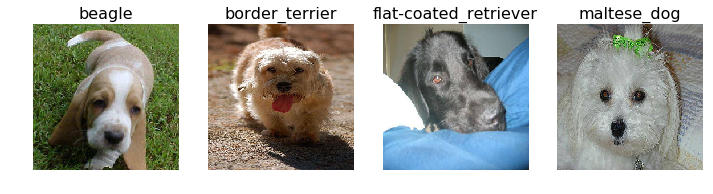

In [60]:
plot_random(test_predictions, test_gen.filenames)

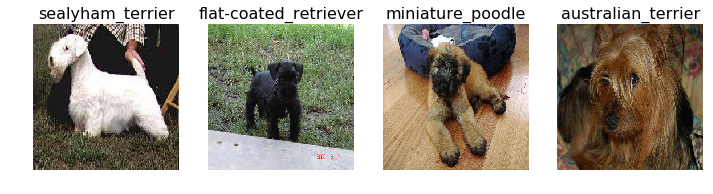

In [63]:
plot_random(test_predictions, test_gen.filenames)

Results seem to be quite reasonable. At least better than random. Let's try a submission.

In [75]:
import pandas as pd

columns = [i[1] for i in sorted(label_to_id.items(), key=lambda x: x[0])]
df = pd.DataFrame(columns=columns, data=test_predictions)
df.insert(0, 'id', [f.split('/')[-1].split('.')[0] for f in test_gen.filenames])
df.to_csv('./submissions/pandas_sub.csv', float_format='%.19f', index=False)

This apparently doesn't beat random. WTF! Score somewhere around 6. Should I max the highest predictions and try again?

In [69]:
preds = np.argmax(test_predictions, axis=1)

In [73]:
import tensorflow as tf

with tf.Session() as sess:
    one_hot_predictions = sess.run(tf.one_hot(preds, 120))

In [76]:
columns = [i[1] for i in sorted(label_to_id.items(), key=lambda x: x[0])]
df = pd.DataFrame(columns=columns, data=one_hot_predictions)
df.insert(0, 'id', [f.split('/')[-1].split('.')[0] for f in test_gen.filenames])
df.to_csv('./submissions/pandas_sub_one_hot.csv', float_format='%.19f', index=False)

Unbelievable. That's even worse! Let's see what sort of log loss i'm getting on the dev set.

In [90]:
dev_gen = gen.flow_from_directory('./data/prepared/dev', batch_size=32, class_mode='categorical', target_size=(224, 224), shuffle=False)

Found 1060 images belonging to 120 classes.


In [91]:
tic = time.time()
dev_predictions = model.predict_generator(dev_gen, steps=dev_gen.samples // 32 + 1)
toc = time.time() - tic

print('Took {0} seconds'.format(round(toc, 2)))  # 163 seconds with larger batch size.

Took 16.2 seconds


In [93]:
np.mean(dev_gen.classes == np.argmax(dev_predictions, axis=1))

0.48490566037735849

In [94]:
with tf.Session() as sess:
    dev_one_hot = sess.run(tf.one_hot(dev_gen.classes, 120))
    print(sess.run(tf.losses.softmax_cross_entropy(dev_one_hot, dev_predictions)))

4.32247


In [96]:
equal_prob = np.full(dev_predictions.shape, 0.00833333333333333)

In [97]:
np.mean(dev_gen.classes == np.argmax(equal_prob, axis=1))

0.0056603773584905656

In [98]:
with tf.Session() as sess:
    dev_one_hot = sess.run(tf.one_hot(dev_gen.classes, 120))
    print(sess.run(tf.losses.softmax_cross_entropy(dev_one_hot, equal_prob)))

4.78748464584


Okay, so the results aren't that crazy. My model just isn't that good. Let me try normalising the images.

### Retrain all dense layers

In [46]:
for layer in model.layers[-3:]: layer.trainable = True

In [47]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [50]:
102764544 + 16781312 + 491640 == 120037496

True

In [54]:
model.fit_generator(
    sample_gen, epochs=2, steps_per_epoch=get_steps(sample_gen),
    validation_data=dev_gen, validation_steps=get_steps(dev_gen))

Epoch 1/2
48/47 [==============================] - 41s - loss: 3.0998 - acc: 0.2973 - val_loss: 4.2439 - val_acc: 0.1717
Epoch 2/2
48/47 [==============================] - 42s - loss: 3.0016 - acc: 0.3424 - val_loss: 4.2411 - val_acc: 0.1755


In [55]:
model.fit_generator(
    train_gen, epochs=5, steps_per_epoch=get_steps(train_gen),
    validation_data=dev_gen, validation_steps=get_steps(dev_gen))

Epoch 1/5
287/286 [==============================] - 166s - loss: 3.5289 - acc: 0.2535 - val_loss: 4.1728 - val_acc: 0.1925
Epoch 2/5
287/286 [==============================] - 166s - loss: 3.4664 - acc: 0.2711 - val_loss: 3.9899 - val_acc: 0.1821
Epoch 3/5
287/286 [==============================] - 166s - loss: 3.3009 - acc: 0.2856 - val_loss: 4.1666 - val_acc: 0.1670
Epoch 4/5
287/286 [==============================] - 166s - loss: 3.2847 - acc: 0.2943 - val_loss: 4.0436 - val_acc: 0.2151
Epoch 5/5
287/286 [==============================] - 166s - loss: 3.1956 - acc: 0.3040 - val_loss: 4.2869 - val_acc: 0.1849


In [56]:
model.fit_generator(
    train_gen, epochs=1, steps_per_epoch=get_steps(train_gen),
    validation_data=dev_gen, validation_steps=get_steps(dev_gen))

Epoch 1/1
287/286 [==============================] - 166s - loss: 3.1919 - acc: 0.3120 - val_loss: 4.2089 - val_acc: 0.1943


In [58]:
model.save_weights('./checkpoints/cnn_fc_retrained.h5')

## Try a simpler model

In [13]:
batch_size = 32

train_datagen = ImageDataGenerator(rescale=1./255)
train_gen = train_datagen.flow_from_directory('./data/prepared/train', batch_size=batch_size, target_size=(224, 224))
dev_gen = train_datagen.flow_from_directory('./data/prepared/dev', batch_size=batch_size, target_size=(224, 224))

Found 9162 images belonging to 120 classes.
Found 1060 images belonging to 120 classes.


In [14]:
vgg16_conv = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add a new top layer
x = vgg16_conv.output
x = Flatten()(x)
predictions = Dense(train_gen.num_class, activation='softmax')(x)

# This is the model we will train
model = Model(inputs=vgg16_conv.input, outputs=predictions)

# First: train only the top layers (which were randomly initialized)
for layer in vgg16_conv.layers:
    layer.trainable = False

model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [80]:
model.fit_generator(
    train_gen, epochs=5, steps_per_epoch=get_steps(train_gen),
    validation_data=dev_gen, validation_steps=get_steps(dev_gen))

Epoch 1/5
287/286 [==============================] - 163s - loss: 6.4570 - acc: 0.1012 - val_loss: 6.3716 - val_acc: 0.1406
Epoch 2/5
287/286 [==============================] - 165s - loss: 1.9793 - acc: 0.6654 - val_loss: 5.1462 - val_acc: 0.1726
Epoch 3/5
287/286 [==============================] - 165s - loss: 0.8596 - acc: 0.8752 - val_loss: 4.6267 - val_acc: 0.2170
Epoch 4/5
287/286 [==============================] - 165s - loss: 0.4801 - acc: 0.9477 - val_loss: 4.6282 - val_acc: 0.2245
Epoch 5/5
287/286 [==============================] - 165s - loss: 0.3126 - acc: 0.9677 - val_loss: 4.5193 - val_acc: 0.2245


In [84]:
model.save_weights('./checkpoints/cnn_simple.h5')

In [15]:
model.load_weights('./checkpoints/cnn_simple.h5')

Starting to overfit. Try to improve it starting with data augementation.

## Data Augmentation

In [24]:
datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

img = load_img('./data/train/000bec180eb18c7604dcecc8fe0dba07.jpg')  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
for batch in datagen.flow(x, batch_size=1,
                          save_to_dir='./data/', save_prefix='dog', save_format='jpeg'):
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely

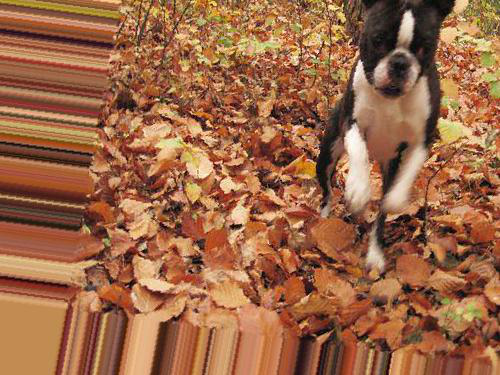

In [25]:
Image.open('./data/dog_0_1309.jpeg')

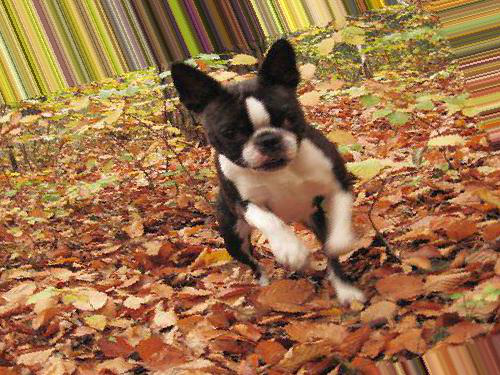

In [26]:
Image.open('./data/dog_0_9321.jpeg')

In [29]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

train_gen = train_datagen.flow_from_directory('./data/prepared/train', batch_size=batch_size, target_size=(224, 224))

test_datagen = ImageDataGenerator(rescale=1./255)
dev_gen = test_datagen.flow_from_directory('./data/prepared/dev', batch_size=batch_size, target_size=(224, 224))

Found 9162 images belonging to 120 classes.
Found 1060 images belonging to 120 classes.


In [30]:
model.fit_generator(
    train_gen, epochs=5, steps_per_epoch=get_steps(train_gen),
    validation_data=dev_gen, validation_steps=get_steps(dev_gen))

Epoch 1/5
287/286 [==============================] - 165s - loss: 2.2085 - acc: 0.5662 - val_loss: 5.5970 - val_acc: 0.2217
Epoch 2/5
287/286 [==============================] - 165s - loss: 1.9623 - acc: 0.6026 - val_loss: 5.8555 - val_acc: 0.2377
Epoch 3/5
287/286 [==============================] - 165s - loss: 1.6452 - acc: 0.6525 - val_loss: 5.7861 - val_acc: 0.2453
Epoch 4/5
287/286 [==============================] - 165s - loss: 1.3191 - acc: 0.7106 - val_loss: 5.6668 - val_acc: 0.2594
Epoch 5/5
287/286 [==============================] - 165s - loss: 1.2671 - acc: 0.7295 - val_loss: 5.8708 - val_acc: 0.2575


In [32]:
model.save_weights('./cnn_simple_aug.h5')

## VGG19 with data aug

In [34]:
from keras.applications.vgg19 import VGG19

In [39]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

train_gen = train_datagen.flow_from_directory('./data/prepared/train', batch_size=batch_size, target_size=(150, 150))

test_datagen = ImageDataGenerator(rescale=1./255)
dev_gen = test_datagen.flow_from_directory('./data/prepared/dev', batch_size=batch_size, target_size=(150, 150))

Found 9162 images belonging to 120 classes.
Found 1060 images belonging to 120 classes.


In [44]:
vgg19_conv = VGG19(weights='imagenet', include_top=False, input_shape=(150, 150, 3))  # Trying smaller image sizes

# Add a new top layer
x = vgg19_conv.output
x = Flatten()(x)
predictions = Dense(train_gen.num_class, activation='softmax')(x)

# This is the model we will train
model = Model(inputs=vgg19_conv.input, outputs=predictions)

# First: train only the top layers (which were randomly initialized)
for layer in vgg19_conv.layers:
    layer.trainable = False

model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [45]:
model.fit_generator(
    train_gen, epochs=5, steps_per_epoch=get_steps(train_gen),
    validation_data=dev_gen, validation_steps=get_steps(dev_gen))

Epoch 1/5
287/286 [==============================] - 122s - loss: 4.6146 - acc: 0.0887 - val_loss: 4.1485 - val_acc: 0.1302
Epoch 2/5
287/286 [==============================] - 121s - loss: 3.5477 - acc: 0.2191 - val_loss: 3.9030 - val_acc: 0.1943
Epoch 3/5
287/286 [==============================] - 121s - loss: 2.9746 - acc: 0.3106 - val_loss: 4.0844 - val_acc: 0.2047
Epoch 4/5
287/286 [==============================] - 121s - loss: 2.6241 - acc: 0.3738 - val_loss: 4.0588 - val_acc: 0.1887
Epoch 5/5
287/286 [==============================] - 121s - loss: 2.3313 - acc: 0.4279 - val_loss: 4.0534 - val_acc: 0.2009


In [48]:
K.set_value(model.optimizer.lr, 0.000001)

In [49]:
model.fit_generator(
    train_gen, epochs=5, steps_per_epoch=get_steps(train_gen),
    validation_data=dev_gen, validation_steps=get_steps(dev_gen))

Epoch 1/5
287/286 [==============================] - 121s - loss: 2.1265 - acc: 0.4775 - val_loss: 4.1615 - val_acc: 0.1991
Epoch 2/5
287/286 [==============================] - 121s - loss: 1.9186 - acc: 0.5178 - val_loss: 4.1542 - val_acc: 0.2104
Epoch 3/5
287/286 [==============================] - 121s - loss: 1.7605 - acc: 0.5494 - val_loss: 4.0845 - val_acc: 0.2038
Epoch 4/5
287/286 [==============================] - 121s - loss: 1.6028 - acc: 0.5895 - val_loss: 4.3180 - val_acc: 0.2019
Epoch 5/5
287/286 [==============================] - 121s - loss: 1.4653 - acc: 0.6172 - val_loss: 4.2194 - val_acc: 0.2264


In [50]:
model.save_weights('./checkpoints/vgg19.h5')

### With L2 reg

In [54]:
from keras import regularizers

In [55]:
model.layers[-1].kernel_regularizer = regularizers.l2(0.01)

In [56]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [57]:
model.optimizer.lr = 0.001

In [58]:
model.fit_generator(
    train_gen, epochs=5, steps_per_epoch=get_steps(train_gen),
    validation_data=dev_gen, validation_steps=get_steps(dev_gen))

Epoch 1/5
287/286 [==============================] - 121s - loss: 1.5114 - acc: 0.6056 - val_loss: 4.3837 - val_acc: 0.2123
Epoch 2/5
287/286 [==============================] - 121s - loss: 1.3944 - acc: 0.6323 - val_loss: 4.3550 - val_acc: 0.2434
Epoch 3/5
287/286 [==============================] - 121s - loss: 1.2591 - acc: 0.6665 - val_loss: 4.4608 - val_acc: 0.1991
Epoch 4/5
287/286 [==============================] - 121s - loss: 1.1547 - acc: 0.6898 - val_loss: 4.4209 - val_acc: 0.2283
Epoch 5/5
287/286 [==============================] - 121s - loss: 1.0752 - acc: 0.7145 - val_loss: 4.5104 - val_acc: 0.2170


In [59]:
model.save_weights('./checkpoints/vgg19_l2.h5')

## Inception with Early Stopping

In [72]:
from keras.applications.inception_v3 import InceptionV3

inception_conv = InceptionV3(
    include_top=False, weights='imagenet', classes=train_gen.num_class)

In [85]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

train_gen = train_datagen.flow_from_directory('./data/prepared/train', batch_size=batch_size, target_size=(299, 299))

test_datagen = ImageDataGenerator(rescale=1./255)
test_gen = test_datagen.flow_from_directory('./data/test', batch_size=batch_size, class_mode=None, target_size=(299, 299), shuffle=False)
dev_gen = test_datagen.flow_from_directory('./data/prepared/dev', batch_size=batch_size, target_size=(299, 299))

Found 9162 images belonging to 120 classes.
Found 10357 images belonging to 1 classes.
Found 1060 images belonging to 120 classes.


In [80]:
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint

# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer
predictions = Dense(train_gen.num_class, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

In [82]:
early_stopping = EarlyStopping(patience=1)
checkpoint = ModelCheckpoint('./checkpoints/inception_v3.h5', save_best_only=True)

In [83]:
model.fit_generator(
    train_gen, epochs=5, steps_per_epoch=get_steps(train_gen),
    validation_data=dev_gen, validation_steps=get_steps(dev_gen), callbacks=[checkpoint, early_stopping])

Epoch 1/5
287/286 [==============================] - 191s - loss: 1.9745 - val_loss: 1.2991
Epoch 2/5
287/286 [==============================] - 175s - loss: 0.9983 - val_loss: 0.9843
Epoch 3/5
287/286 [==============================] - 175s - loss: 0.8474 - val_loss: 1.0625
Epoch 4/5
287/286 [==============================] - 175s - loss: 0.7805 - val_loss: 0.7835
Epoch 5/5
287/286 [==============================] - 174s - loss: 0.7294 - val_loss: 0.7277


In [84]:
model.fit_generator(
    train_gen, epochs=2, steps_per_epoch=get_steps(train_gen),
    validation_data=dev_gen, validation_steps=get_steps(dev_gen), callbacks=[checkpoint, early_stopping])

Epoch 1/2
287/286 [==============================] - 180s - loss: 0.6965 - val_loss: 0.6964
Epoch 2/2
287/286 [==============================] - 175s - loss: 0.6772 - val_loss: 0.7578


In [86]:
K.set_value(model.optimizer.lr, 0.00001)

In [87]:
model.fit_generator(
    train_gen, epochs=2, steps_per_epoch=get_steps(train_gen),
    validation_data=dev_gen, validation_steps=get_steps(dev_gen), callbacks=[checkpoint, early_stopping])

Epoch 1/2
287/286 [==============================] - 181s - loss: 0.6407 - val_loss: 0.8440
Epoch 2/2
287/286 [==============================] - 175s - loss: 0.6095 - val_loss: 0.7728


In [88]:
# model.load_weights('./checkpoints/inception_v3.h5')

AttributeError: 'Model' object has no attribute 'load'

In [89]:
tic = time.time()
test_predictions = model.predict_generator(test_gen, steps=test_gen.samples // 32 + 1)
toc = time.time() - tic

print('Took {0} seconds'.format(round(toc, 2)))  # 163 seconds with larger batch size.

Took 162.92 seconds


In [90]:
import pandas as pd

columns = [i[1] for i in sorted(label_to_id.items(), key=lambda x: x[0])]
df = pd.DataFrame(columns=columns, data=test_predictions)
df.insert(0, 'id', [f.split('/')[-1].split('.')[0] for f in test_gen.filenames])
df.to_csv('./submissions/inception.csv', float_format='%.19f', index=False)

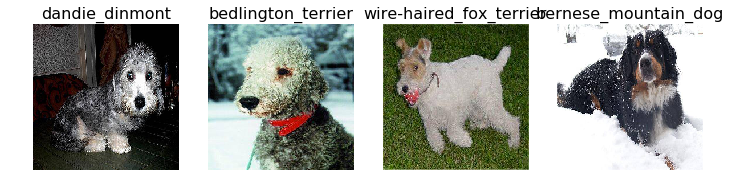

In [92]:
plot_random(test_predictions, test_gen.filenames)

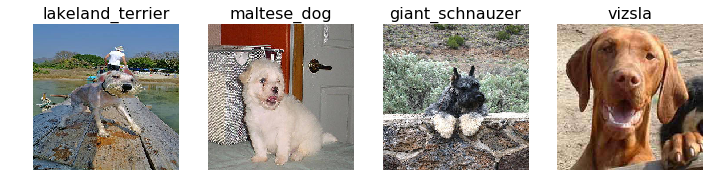

In [93]:
plot_random(test_predictions, test_gen.filenames)

You advanced 39 places on the leaderboard!

Your submission scored 0.85987, which is an improvement of your previous score of 3.76780.

Currently at position 68.

### Add L2

In [11]:
batch_size = 32

In [12]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

train_gen = train_datagen.flow_from_directory('./data/prepared/train', batch_size=batch_size, target_size=(299, 299))

test_datagen = ImageDataGenerator(rescale=1./255)
test_gen = test_datagen.flow_from_directory('./data/test', batch_size=batch_size, class_mode=None, target_size=(299, 299), shuffle=False)
dev_gen = test_datagen.flow_from_directory('./data/prepared/dev', batch_size=batch_size, target_size=(299, 299))

Found 9162 images belonging to 120 classes.
Found 10357 images belonging to 1 classes.
Found 1060 images belonging to 120 classes.


In [42]:
inception_conv = InceptionV3(
    include_top=False, weights='imagenet', classes=train_gen.num_class)

# add a global spatial average pooling layer
x = inception_conv.output
x = GlobalAveragePooling2D()(x)

x = Dense(1024, activation='relu')(x)

l2_reg = l2(0.001)
# and a logistic layer with L2
predictions = Dense(
    train_gen.num_class, activation='softmax',
    kernel_regularizer=l2_reg)(x)

# this is the model we will train
model = Model(inputs=inception_conv.input, outputs=predictions)

for layer in inception_conv.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

In [43]:
model.load_weights('./checkpoints/inception_v3.h5')

In [51]:
early_stopping = EarlyStopping(patience=1)
checkpoint = ModelCheckpoint('./checkpoints/inception_v3_l2.h5', save_best_only=True)
reduce_lr = ReduceLROnPlateau(patience=3, verbose=1)

In [46]:
model.fit_generator(
    train_gen, epochs=5, steps_per_epoch=get_steps(train_gen),
    validation_data=dev_gen, validation_steps=get_steps(dev_gen),
    callbacks=[checkpoint, early_stopping, reduce_lr])

Epoch 1/5
287/286 [==============================] - 206s - loss: 1.1635 - val_loss: 1.1359
Epoch 2/5
287/286 [==============================] - 184s - loss: 0.9657 - val_loss: 0.9767
Epoch 3/5
287/286 [==============================] - 184s - loss: 0.8836 - val_loss: 0.9920
Epoch 4/5
287/286 [==============================] - 183s - loss: 0.8755 - val_loss: 0.9340
Epoch 5/5
287/286 [==============================] - 182s - loss: 0.8468 - val_loss: 1.0221


In [47]:
K.get_value(model.optimizer.lr)

0.001

In [48]:
K.set_value(model.optimizer.lr, 0.0001)

In [49]:
model.fit_generator(
    train_gen, epochs=5, steps_per_epoch=get_steps(train_gen),
    validation_data=dev_gen, validation_steps=get_steps(dev_gen),
    callbacks=[checkpoint, early_stopping, reduce_lr])

Epoch 1/5
287/286 [==============================] - 188s - loss: 0.6694 - val_loss: 0.9488
Epoch 2/5
287/286 [==============================] - 184s - loss: 0.6350 - val_loss: 0.8766
Epoch 3/5
287/286 [==============================] - 184s - loss: 0.6439 - val_loss: 0.9238
Epoch 4/5
287/286 [==============================] - 183s - loss: 0.6157 - val_loss: 0.8517
Epoch 5/5
287/286 [==============================] - 182s - loss: 0.6258 - val_loss: 0.9267


In [50]:
K.set_value(model.optimizer.lr, 0.00001)

In [52]:
model.fit_generator(
    train_gen, epochs=5, steps_per_epoch=get_steps(train_gen),
    validation_data=dev_gen, validation_steps=get_steps(dev_gen),
    callbacks=[checkpoint, early_stopping, reduce_lr])

Epoch 1/5
287/286 [==============================] - 189s - loss: 0.6081 - val_loss: 0.8981
Epoch 2/5
287/286 [==============================] - 181s - loss: 0.6048 - val_loss: 0.9011
Epoch 3/5
287/286 [==============================] - 183s - loss: 0.5995 - val_loss: 0.9027


### With Dropout on FC layer

In [56]:
inception_conv = InceptionV3(
    include_top=False, weights='imagenet', classes=train_gen.num_class)

# add a global spatial average pooling layer
x = inception_conv.output
x = GlobalAveragePooling2D()(x)

x = Dense(1024, activation='relu')(x)

x = Dropout(0.2)(x)

predictions = Dense(train_gen.num_class, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=inception_conv.input, outputs=predictions)

for layer in inception_conv.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

In [57]:
model.load_weights('./checkpoints/inception_v3.h5')

In [61]:
early_stopping = EarlyStopping(patience=3)
checkpoint = ModelCheckpoint('./checkpoints/inception_v3_dropout.h5', save_best_only=True)
reduce_lr = ReduceLROnPlateau(patience=2, verbose=1)

In [60]:
model.fit_generator(
    train_gen, epochs=10, steps_per_epoch=get_steps(train_gen),
    validation_data=dev_gen, validation_steps=get_steps(dev_gen),
    callbacks=[checkpoint, early_stopping, reduce_lr])

Epoch 1/10
287/286 [==============================] - 213s - loss: 0.7304 - val_loss: 0.6552
Epoch 2/10
287/286 [==============================] - 184s - loss: 0.6912 - val_loss: 0.7560
Epoch 3/10
287/286 [==============================] - 183s - loss: 0.6757 - val_loss: 0.6597


In [62]:
model.fit_generator(
    train_gen, epochs=5, steps_per_epoch=get_steps(train_gen),
    validation_data=dev_gen, validation_steps=get_steps(dev_gen),
    callbacks=[checkpoint, early_stopping, reduce_lr])

Epoch 1/5
287/286 [==============================] - 188s - loss: 0.6492 - val_loss: 0.8235
Epoch 2/5
287/286 [==============================] - 185s - loss: 0.6694 - val_loss: 0.7524
Epoch 3/5
287/286 [==============================] - 184s - loss: 0.6416 - val_loss: 0.9212
Epoch 4/5
287/286 [==============================] - 184s - loss: 0.6338 - val_loss: 0.8695
Epoch 5/5
286/286 [============================>.] - ETA: 0s - loss: 0.6079
Epoch 00004: reducing learning rate to 0.00010000000474974513.
287/286 [==============================] - 181s - loss: 0.6071 - val_loss: 0.7958


In [63]:
model.fit_generator(
    train_gen, epochs=2, steps_per_epoch=get_steps(train_gen),
    validation_data=dev_gen, validation_steps=get_steps(dev_gen),
    callbacks=[checkpoint, early_stopping, reduce_lr])

Epoch 1/2
287/286 [==============================] - 182s - loss: 0.4044 - val_loss: 0.6757
Epoch 2/2
287/286 [==============================] - 178s - loss: 0.3362 - val_loss: 0.5845


In [64]:
checkpoint = ModelCheckpoint('./checkpoints/inception_v3_dropout_v2.h5', save_best_only=True)

In [65]:
model.fit_generator(
    train_gen, epochs=5, steps_per_epoch=get_steps(train_gen),
    validation_data=dev_gen, validation_steps=get_steps(dev_gen),
    callbacks=[checkpoint, early_stopping, reduce_lr])

Epoch 1/5
287/286 [==============================] - 180s - loss: 0.3128 - val_loss: 0.6429
Epoch 2/5
287/286 [==============================] - 175s - loss: 0.3019 - val_loss: 0.6684
Epoch 3/5
287/286 [==============================] - 176s - loss: 0.3087 - val_loss: 0.6874
Epoch 4/5
286/286 [============================>.] - ETA: 0s - loss: 0.2973
Epoch 00003: reducing learning rate to 1.0000000474974514e-05.
287/286 [==============================] - 174s - loss: 0.2967 - val_loss: 0.7156
Epoch 5/5
287/286 [==============================] - 175s - loss: 0.2900 - val_loss: 0.6491


In [67]:
model.fit_generator(
    train_gen, epochs=1, steps_per_epoch=get_steps(train_gen),
    validation_data=dev_gen, validation_steps=get_steps(dev_gen),
    callbacks=[checkpoint, early_stopping, reduce_lr])

Epoch 1/1
287/286 [==============================] - 181s - loss: 0.2784 - val_loss: 0.6485


In [68]:
tic = time.time()
test_predictions = model.predict_generator(test_gen, steps=test_gen.samples // 32 + 1)
toc = time.time() - tic

print('Took {0} seconds'.format(round(toc, 2)))  # 163 seconds with larger batch size.

Took 160.47 seconds


In [69]:
import pandas as pd

columns = [i[1] for i in sorted(label_to_id.items(), key=lambda x: x[0])]
df = pd.DataFrame(columns=columns, data=test_predictions)
df.insert(0, 'id', [f.split('/')[-1].split('.')[0] for f in test_gen.filenames])
df.to_csv('./submissions/inception_dropout.csv', float_format='%.19f', index=False)

You advanced 5 places on the leaderboard!

Your submission scored 0.70816, which is an improvement of your previous score of 0.85987.

Up to 63rd position.